Check GPU

In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

Imports

In [2]:
import sys, os, csv
from urllib import request, error
from PIL import Image
from io import BytesIO
import boto3
import random
import base64

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import io
from io import BytesIO

import time
import tempfile
import pickle
from random import shuffle
import multiprocessing
from multiprocessing import Process, Manager

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.data import TFRecordDataset

from skimage.transform import resize

In [5]:
print('Using tensorflow', tf.__version__)
print('Using keras', keras.__version__)

Using tensorflow 1.10.1
Using keras 2.1.6-tf


Constants

In [6]:
# set constants
model_dir = '../models'
tfrecord_dir = 'tf_data'

should_load_from_s3 = True

batch_size = 64
tfrecord_batch_size = 500
num_classes = 14940

target_height = 100
target_width = 100
color_mode = 'rgb'
depth = 3 if color_mode == 'rgb' else 1

n_layers_to_tune = 0

n_cpus = multiprocessing.cpu_count()
n_workers = n_cpus - 1 # None defaults to n_cpus
print('There are', n_cpus, 'cpu cores available')

There are 4 cpu cores available


Setup

In [7]:
def debug(*string):
    if should_debug:
        print(string)

In [8]:
s3 = boto3.resource('s3')
bucket_name = 'landmark-data-12345'
bucket = s3.Bucket(bucket_name)

In [9]:
if should_load_from_s3:
    prefix = 's3://landmark-data-12345/'
    filenames = [ prefix + obj.key for obj in bucket.objects.filter(Prefix=tfrecord_dir).all() if obj.key.endswith('tfrecord') ]
else:
    filenames = [ tfrecord_dir+filename for filename in os.listdir(tfrecord_dir) if filename.endswith('tfrecord') ]

# filenames = filenames[:1]
print('there are', len(filenames), 'tfrecord files')
print('for example:', filenames[0])

there are 2638 tfrecord files
for example: s3://landmark-data-12345/tf_data/1.tfrecord


Helper funcs

start of byte string: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'
type of byte string: <class 'bytes'>
len of byte string: 482066


shape: [1600, 1200, 3]


type of img: <class 'numpy.ndarray'>
shape of img: (1600, 1200, 3)


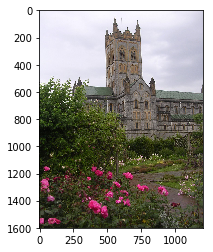

In [10]:
# with jpeg string
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
record_iterator = tf.python_io.tf_record_iterator(path=filenames[0])

for record_string in record_iterator:

    example = tf.train.Example()
    example.ParseFromString(record_string)
    
    img_byte_string = example.features.feature['image'].bytes_list.value[0]
    print('start of byte string:', img_byte_string[:20])
    print('type of byte string:', type(img_byte_string))
    print('len of byte string:', len(img_byte_string))
    print('\n')
    
    shape = example.features.feature['shape'].int64_list.value    
    print('shape:', shape)
    print('\n')

    tempBuff = io.BytesIO()
    tempBuff.write(img_byte_string)
    tempBuff.seek(0)
    
    image_data = Image.open(tempBuff).convert("RGB")
    image_data = np.array(image_data).reshape(shape)
    print('type of img:', type(image_data))
    print('shape of img:', image_data.shape)

    imshow(image_data)

    break

In [11]:
def preprocess_fn(tensor):
    features = {
        'label': tf.FixedLenFeature([], dtype=tf.int64),
        'image': tf.FixedLenFeature([], dtype=tf.string),
#         'shape': tf.FixedLenFeature([], dtype=tf.int64)
    }
    example = tf.parse_single_example(tensor, features)

    image_data = tf.image.decode_jpeg(example['image'], channels=depth)
    
    x = tf.image.resize_image_with_pad(tf.cast(image_data, tf.float32), target_height, target_width)
    
    y = tf.one_hot(tf.cast(example['label'], tf.int32), num_classes)
    
    return x, y

dataset = TFRecordDataset(filenames)

dataset = dataset.apply(tf.contrib.data.map_and_batch(
    preprocess_fn, batch_size,
    num_parallel_batches=n_workers))

dataset = dataset.repeat()
# dataset = dataset.prefetch(tf.contrib.data.AUTOTUNE) # todo: test without prefetch

Instructions for updating:
Use the `axis` argument instead


Model

In [12]:
# create model
pre_model = applications.VGG19(weights="imagenet", 
                           include_top=False, 
                           input_shape=(target_height, target_width, depth))

model = Sequential()
for idx, layer in enumerate(pre_model._layers):
    if idx < len(pre_model._layers) - n_layers_to_tune:
        layer.trainable = False
    model.add(layer)
    
model.add(Flatten(input_shape=pre_model.output_shape[1:]))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 25, 25, 256)       295168    
__________

In [14]:
# compile model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy', 'categorical_accuracy'])

Train

In [15]:
# tell model to save after each epoch
class SaveEachEpoch(Callback):
    def on_epoch_end(self, epoch, logs={}):
        epoch = epoch + 1
        print('SEE: saving model for epoch', epoch)
        
        filename1 = '/small_landmark_model_' + str(epoch) + '.h5'
        filename2 = '/small_landmark_model_weights_' + str(epoch) + '.h5'
        
        source1 = model_dir+filename1
        dest1 = 'models'+filename1
        source2 = model_dir+filename2
        dest2 = 'models'+filename2

        try:
            self.model.save(source1)
            bucket.upload_file(source1, dest1)

            self.model.save_weights(source2)
            bucket.upload_file(source2, dest2)

        except:
            print('SEE: error saving model')
            return
        
        print('SEE: done saving model')

In [16]:
# train model
num_examples = tfrecord_batch_size * len(filenames)
steps_per_epoch = (num_examples // batch_size)

print('training on', num_examples, 'examples')

model.fit(dataset.make_one_shot_iterator(),
#             validation_data=validation_dataset.make_one_shot_iterator(),
            epochs=10,
            steps_per_epoch=steps_per_epoch,
#             callbacks=[SaveEachEpoch()],
            verbose=1
            )

training on 1319000 examples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[512,14940] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_2/kernel/Initializer/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, _class=["loc:@dense_2/kernel/Assign"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/kernel/Initializer/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dense_2/kernel/Initializer/random_uniform/RandomUniform', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2907, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-7d7c2486b0cf>", line 17, in <module>
    model.add(Dense(num_classes, activation='softmax'))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/checkpointable/base.py", line 364, in _method_wrapper
    method(self, *args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py", line 184, in add
    output_tensor = layer(self.outputs[0])
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 728, in __call__
    self.build(input_shapes)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py", line 917, in build
    trainable=True)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 565, in add_weight
    aggregation=aggregation)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/checkpointable/base.py", line 535, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1918, in make_variable
    aggregation=aggregation)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2443, in variable
    aggregation=aggregation)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2425, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2395, in default_variable_creator
    constraint=constraint)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 312, in __init__
    constraint=constraint)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 417, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1903, in <lambda>
    shape, dtype=dtype, partition_info=partition_info)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py", line 489, in __call__
    shape, -limit, limit, dtype, seed=self.seed)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 242, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 732, in random_uniform
    name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[512,14940] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_2/kernel/Initializer/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, _class=["loc:@dense_2/kernel/Assign"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/kernel/Initializer/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
# todo: print decoded image and corresponding label